In [71]:
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd

# Question 2.4

In [72]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [84]:
import numpy as np

def load_data(log_file, value='Eval_AverageReturn', data='Train_EnvstepsSoFar'):
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()
    values = event_acc.Scalars(value)
    if data:
        env_steps = [
            e.value for e in event_acc.Scalars(data)
        ]
    else:
        env_steps = [
            e.step for e in values
        ]
    values = [
        e.value for e in event_acc.Scalars(value)
    ]

    return np.array(env_steps), np.array(values)

def smooth_data(data, n):
    smoothed_data = []
    for i in range(len(data)):
        ds = data[max(i-n, 0): i+1]
        smoothed_data.append(sum(ds) / len(ds))
    return smoothed_data

In [75]:
def plot(log_file, value='Eval_AverageReturn'):
    x, y = load_data(log_file, value = value, data = None)
    plt.plot(x,y)
    plt.xlabel("timesteps")
    plt.ylabel(value)

In [74]:
# Do not run, this will mess up the indices used later
experiment_paths = sorted([os.path.join("data_exp", filename) for filename in os.listdir("data_exp")])
baseline_paths = sorted([os.path.join("data_baseline", filename) for filename in os.listdir("data_baseline")])

In [76]:
print(len(experiment_paths))
print(len(baseline_paths))
for i, path in enumerate(experiment_paths):
    # print(i, ": ", path)
    pass

675
225


In [77]:
import re

def search_strings(strings, pattern_dict):
    result = []
    
    for s in strings:
        matches = []
        for key, value in pattern_dict.items():
            pattern = fr'{re.escape(key)}_{re.escape(str(value))}'
            if re.search(pattern, s):
                matches.append(True)
            else:
                matches.append(False)
        
        if all(matches):
            result.append(s)
    
    return result

best_baseline_params = {"schedule_timesteps": 10000, "final_p": 0.02, "initial_p": 1.0, "schedule_type": "linear", "lr": 0.1, "batch_size": 100, "base_config": "dqn_basic", "env_name": "CartPole-v1", "target_update_period": 1000, "total_steps": 10000}
best_baseline_paths = search_strings(baseline_paths, best_baseline_params)
print(best_baseline_paths)

best_exp_params = {"alpha": 0.4, "n": 10000, "p": 0.1, "threshold": 0.2, "eps_max": 0.3, "schedule_type": "adaptive", "lr": 0.001, "batch_size": 10, "base_config": "dqn_basic", "env_name": "CartPole-v1", "target_update_period": 1000, "total_steps": 10000}
best_exp_paths = search_strings(experiment_paths, best_exp_params)
print(best_exp_paths)

['data_baseline/hw3_dqn_lr_0.1_batch_size_100_base_config_dqn_basic_env_name_CartPole-v1_target_update_period_1000_total_steps_10000_schedule_timesteps_10000_final_p_0.02_initial_p_1.0_schedule_type_linear_CartPole-v1_s64_l2_d0.99_seed_1_06-12-2023_16-31-55', 'data_baseline/hw3_dqn_lr_0.1_batch_size_100_base_config_dqn_basic_env_name_CartPole-v1_target_update_period_1000_total_steps_10000_schedule_timesteps_10000_final_p_0.02_initial_p_1.0_schedule_type_linear_CartPole-v1_s64_l2_d0.99_seed_1_06-12-2023_16-36-25', 'data_baseline/hw3_dqn_lr_0.1_batch_size_100_base_config_dqn_basic_env_name_CartPole-v1_target_update_period_1000_total_steps_10000_schedule_timesteps_10000_final_p_0.02_initial_p_1.0_schedule_type_linear_CartPole-v1_s64_l2_d0.99_seed_2_06-12-2023_16-31-55', 'data_baseline/hw3_dqn_lr_0.1_batch_size_100_base_config_dqn_basic_env_name_CartPole-v1_target_update_period_1000_total_steps_10000_schedule_timesteps_10000_final_p_0.02_initial_p_1.0_schedule_type_linear_CartPole-v1_s64_l

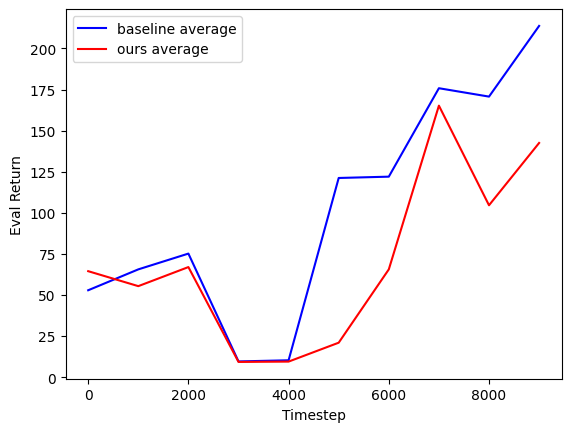

In [78]:
for p in best_baseline_paths:
    total_x, total_y = [], []
    for f in os.listdir(p):
        cartpole_file = os.path.join(p, f)
        x, y = load_data(cartpole_file, value = "eval_return", data = None)
        total_x.append(x)
        total_y.append(y)
        # plt.plot(x, y, "b", label="baseline")

x, y = sum(total_x) / len(total_x), sum(total_y) / len(total_y)
plt.plot(x, y, "b", label="baseline average")
    
for p in best_exp_paths:
    total_x, total_y = [], []
    for f in os.listdir(p):
        cartpole_file = os.path.join(p, f)
        x, y = load_data(cartpole_file, value = "eval_return", data = None)
        total_x.append(x)
        total_y.append(y)
        # plt.plot(x, y, "b", label="baseline")

x, y = sum(total_x) / len(total_x), sum(total_y) / len(total_y)
plt.plot(x, y, "r", label="ours average")
plt.xlabel("Timestep")
plt.ylabel("Eval Return")
plt.legend()


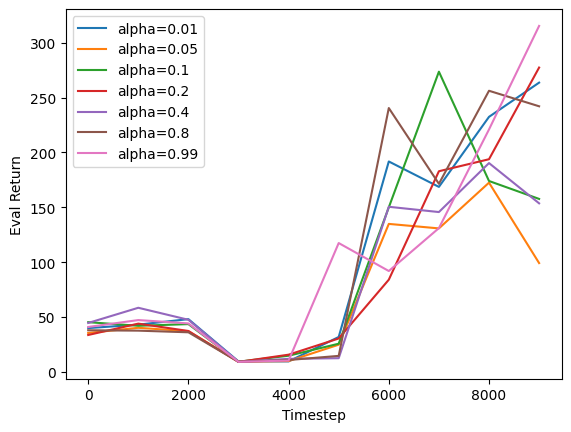

In [79]:
paths = []
alpha_vals = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 0.99]
paths = search_strings(experiment_paths, {"alpha": 0.1, "seed": 1})
t = 0

timestamps = []
for path in paths:
    timestamp = path.split("seed_1_")[1]
    timestamps.append(timestamp)

paths = search_strings(experiment_paths, {"seed_1": timestamps[t]})
paths += search_strings(experiment_paths, {"seed_2": timestamps[t]})
paths += search_strings(experiment_paths, {"seed_3": timestamps[t]})

alpha_paths = []
for val in alpha_vals:
    p = search_strings(paths, {"alpha": val})
    if len(p) > 0:
        alpha_paths.append((val, p))
    
for val, paths in alpha_paths:
    total_x, total_y = [], []
    for p in paths:
        for f in os.listdir(p):
            data_file = os.path.join(p, f)
            x, y = load_data(data_file, value="eval_return", data=None)
            total_x.append(x)
            total_y.append(y)
    x, y = sum(total_x) / len(total_x), sum(total_y) / len(total_y)
    plt.plot(x, y, label=f"alpha={val}")
plt.xlabel("Timestep")
plt.ylabel("Eval Return")
plt.legend()


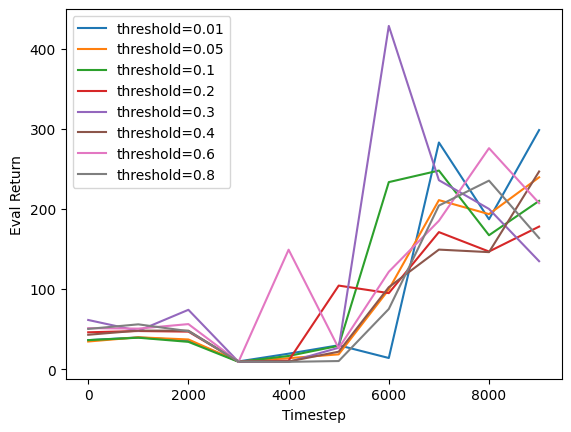

In [80]:
paths = []
threshold_vals = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8]
paths = search_strings(experiment_paths, {"threshold": 0.1, "seed": 1})
t = 0

timestamps = []
for path in paths:
    timestamp = path.split("seed_1_")[1]
    timestamps.append(timestamp)

paths = search_strings(experiment_paths, {"seed_1": timestamps[t]})
paths += search_strings(experiment_paths, {"seed_2": timestamps[t]})
paths += search_strings(experiment_paths, {"seed_3": timestamps[t]})

threshold_paths = []
for val in threshold_vals:
    p = search_strings(paths, {"threshold": val})
    if len(p) > 0:
        threshold_paths.append((val, p))
    
for val, paths in threshold_paths:
    total_x, total_y = [], []
    for p in paths:
        for f in os.listdir(p):
            data_file = os.path.join(p, f)
            x, y = load_data(data_file, value="eval_return", data=None)
            total_x.append(x)
            total_y.append(y)
    x, y = sum(total_x) / len(total_x), sum(total_y) / len(total_y)
    plt.plot(x, y, label=f"threshold={val}")
plt.xlabel("Timestep")
plt.ylabel("Eval Return")
plt.legend()



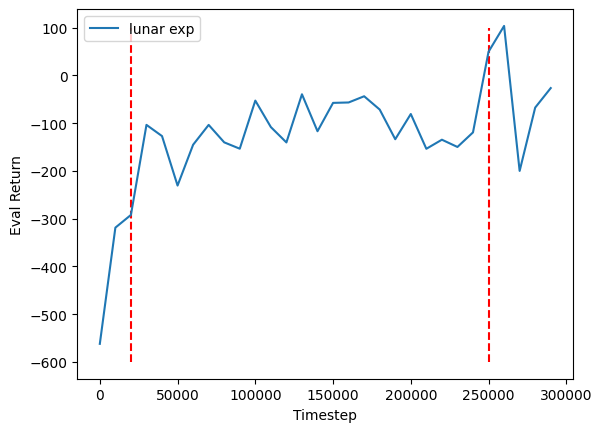

In [94]:
final_paths = sorted([os.path.join("data", filename) for filename in os.listdir("data")])

p = final_paths[0]
plt.vlines((250000, 20000), -600, 100, colors="r", linestyles="dashed")
for f in os.listdir(p):
    data_file = os.path.join(p, f)
    x, y = load_data(data_file, value = "eval_return", data = None)
    plt.plot(x,y, label="lunar exp")
plt.xlabel("Timestep")
plt.ylabel("Eval Return")
plt.legend()

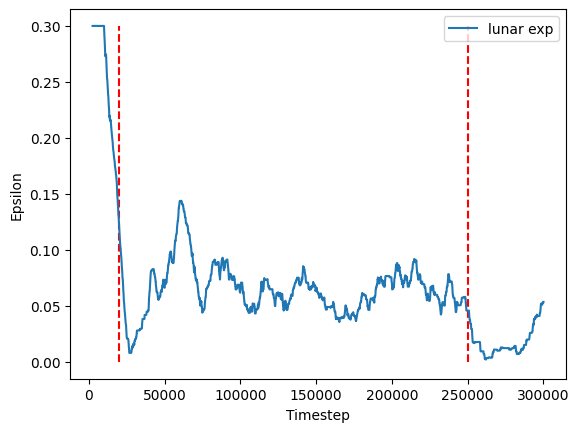

In [95]:
p = final_paths[0]
plt.vlines((250000, 20000), 0, 0.3, colors="r", linestyles="dashed")
for f in os.listdir(p):
    data_file = os.path.join(p, f)
    x, y = load_data(data_file, value = "epsilon", data = None)
    y = smooth_data(y, n=500)
    plt.plot(x,y, label="lunar exp")
plt.xlabel("Timestep")
plt.ylabel("Epsilon")
plt.legend()

The red lines indicate where eval return spiked causing the scheduler to decrease epsilon.